In [92]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
import pymc as pm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from datetime import datetime
from tqdm.notebook import tqdm

In [2]:
surface_df_path = "data/clean_daylight_surface_ts.csv"

In [3]:
raw_df = pd.read_csv(surface_df_path)
raw_df["date_time"] = pd.to_datetime(raw_df["date_time"])
raw_df["plant_num"] = raw_df["plant_num"].astype(str)
raw_df["date"] = raw_df["date_time"].dt.normalize()
raw_df

,img_name,plant_num,date_time,surface,date
0,lettuce1_2024-06-15_07.jpg,1,2024-06-15 07:00:00,0.000000,2024-06-15
1,lettuce1_2024-06-15_08.jpg,1,2024-06-15 08:00:00,0.000000,2024-06-15
2,lettuce1_2024-06-15_09.jpg,1,2024-06-15 09:00:00,0.000000,2024-06-15
3,lettuce1_2024-06-15_10.jpg,1,2024-06-15 10:00:00,0.000000,2024-06-15
4,lettuce1_2024-06-15_11.jpg,1,2024-06-15 11:00:00,0.000000,2024-06-15
...,...,...,...,...,...
5499,lettuce8_2024-07-26_12.jpg,8,2024-07-26 12:00:00,281.915085,2024-07-26
5500,lettuce8_2024-07-26_13.jpg,8,2024-07-26 13:00:00,281.886747,2024-07-26
5501,lettuce8_2024-07-26_14.jpg,8,2024-07-26 14:00:00,280.357834,2024-07-26
5502,lettuce8_2024-07-26_15.jpg,8,2024-07-26 15:00:00,281.198534,2024-07-26


In [4]:
df = raw_df.groupby(["plant_num", "date"])["surface"].mean().sort_index().reset_index()
df["days_from_start"] = (df["date"] - df.groupby('plant_num')["date"].transform('min')).dt.days
mean_df = df.groupby("days_from_start")["surface"].mean().sort_index().reset_index()
df.head()

,plant_num,date,surface,days_from_start
0,1,2024-06-15,0.000000,0
1,1,2024-06-16,0.158717,1
2,1,2024-06-17,0.340680,2
3,1,2024-06-18,0.523646,3
4,1,2024-06-19,0.351673,4


## Data preprocessing for ARIMA

In [5]:
def plot_ts(x, y, df, hue=None):
    fig = plt.figure(figsize=(12, 6))

    if hue:
        sns.lineplot(x=x, y=y, data=df, hue=hue)
    else:
        sns.lineplot(x=x, y=y, data=df)
    plt.xlabel('Date Time')
    plt.ylabel('Surface cm2')
    plt.title('Plant surface cm2 over time')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()

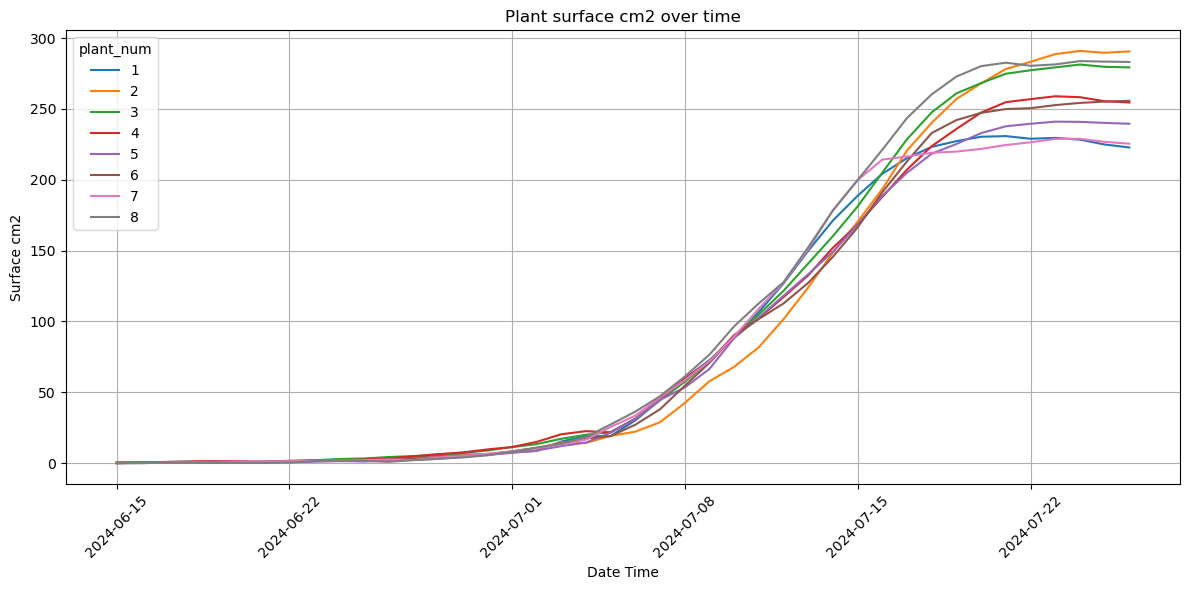

In [7]:
plot_ts(x="date", y="surface", df=df, hue="plant_num")

**First order diff**

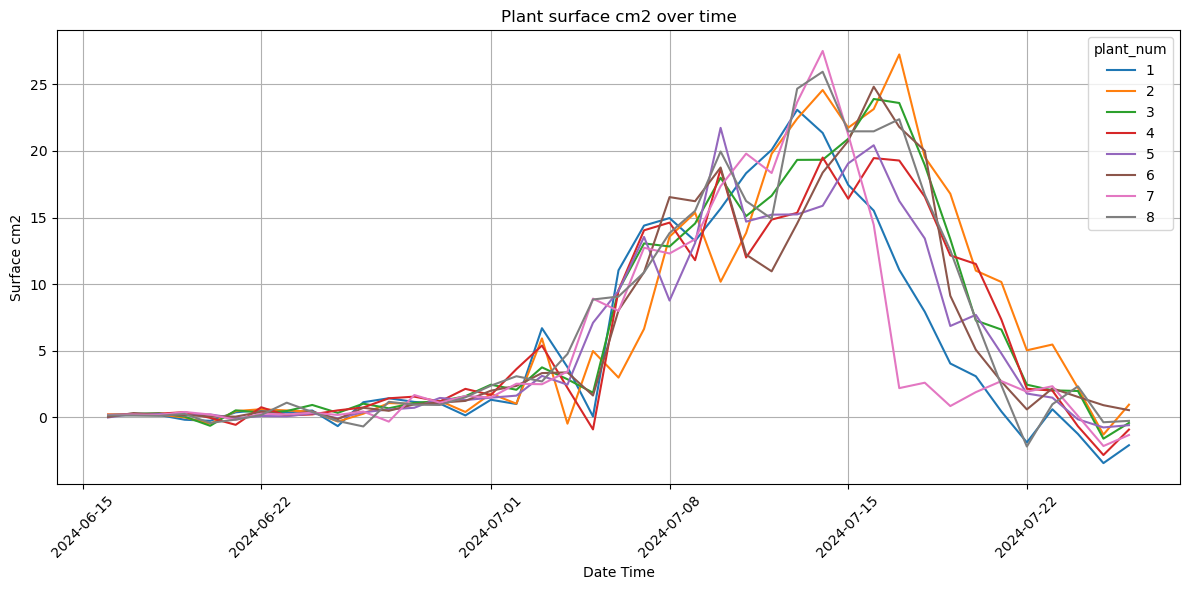

In [38]:
df["surface_diff"] = df.groupby("plant_num")["surface"].diff()
plot_ts(x="date", y="surface_diff", df=df, hue="plant_num")

**Second order diff**

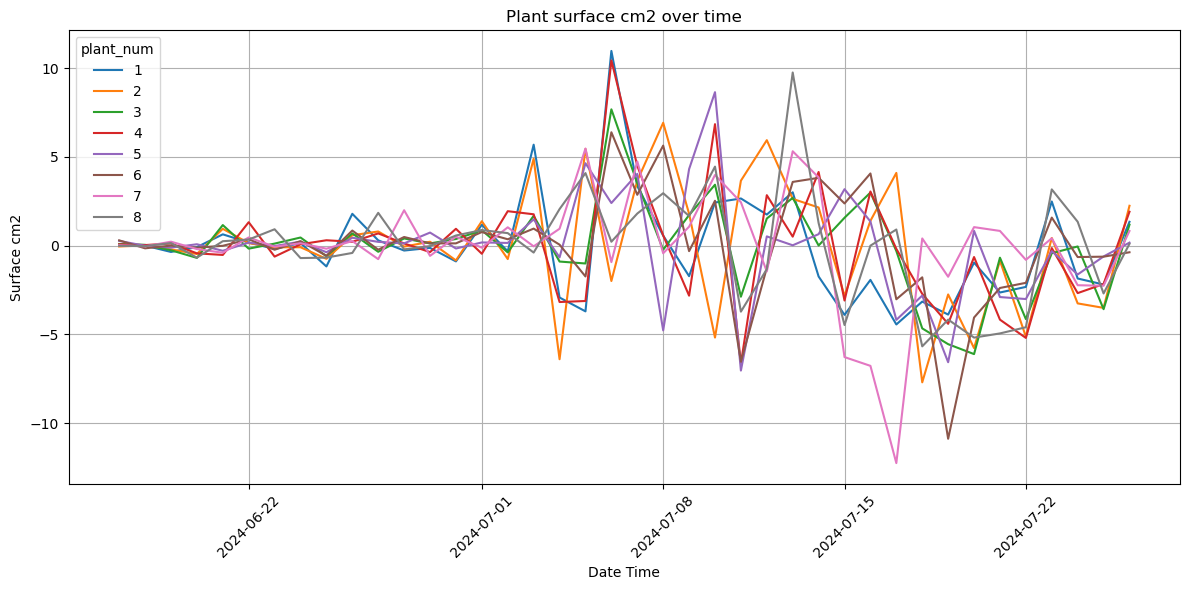

In [40]:
df["surface_diff2"] = df.groupby("plant_num")["surface_diff"].diff()
plot_ts(x="date", y="surface_diff2", df=df, hue="plant_num")

In [44]:
import statsmodels
from statsmodels.tsa.stattools import adfuller

# Perform ADF test on the surface area data
adf_test = []
for plant in tqdm(range(1, 9)):
    result = adfuller(df[df["plant_num"] == str(plant)]['surface_diff2'].dropna())
    verdict = result[1] < 0.05
    adf_test.append([plant, result[0], result[1], verdict])
adf_test = pd.DataFrame(adf_test, columns=["plant", "ADF statistic", "p-value", "is_stationary"])
adf_test

  0%|          | 0/8 [00:00<?, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,plant,ADF statistic,p-value,is_stationary
0,1,-5.247463,7.028350e-06,True
1,2,-6.446914,1.557655e-08,True
2,3,-4.308054,4.301618e-04,True
3,4,-2.403632,1.407138e-01,False
4,5,-6.405203,1.950997e-08,True
5,6,-3.634367,5.136999e-03,True
6,7,-4.530553,1.730993e-04,True
7,8,-2.028267,2.743180e-01,False


## ARIMA

In [19]:
train_plants = ["1", "2", "3", "4", "5", "6"]
test_plants = ["7", "8"]

train_df = df[df['plant_num'].isin(train_plants)]
test_df = df[df['plant_num'].isin(test_plants)]

In [58]:
train_gap_df = []
gap_days = 10
for plant in train_plants:
    temp_df = train_df[train_df["plant_num"] == plant].copy()
    last_date = temp_df['date'].max()
    last_day = temp_df["days_from_start"].max()
    nan_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                                  periods=gap_days, 
                                  freq='D')
    nan_days = list(range(last_day + 1, last_day + gap_days + 1, 1))
    nan_df = pd.DataFrame({'plant_num': [plant] * gap_days, 
                           'date': nan_dates, 
                           'surface': [np.nan] * gap_days,
                           'days_from_start': nan_days})
    train_gap_df.append(pd.concat([temp_df, nan_df]))
train_gap_df = pd.concat(train_gap_df)

In [59]:
test_days = list(range(16, 42))
train_gap_df = pd.concat([train_gap_df, test_df[(test_df['plant_num'] == '7') & (~test_df["days_from_start"].isin(test_days))]])

In [60]:
train_gap_df

,plant_num,date,surface,days_from_start
0,1,2024-06-15,0.000000,0
1,1,2024-06-16,0.158717,1
2,1,2024-06-17,0.340680,2
3,1,2024-06-18,0.523646,3
4,1,2024-06-19,0.351673,4
...,...,...,...,...
263,7,2024-06-26,2.549827,11
264,7,2024-06-27,2.235569,12
265,7,2024-06-28,3.916571,13
266,7,2024-06-29,5.021333,14


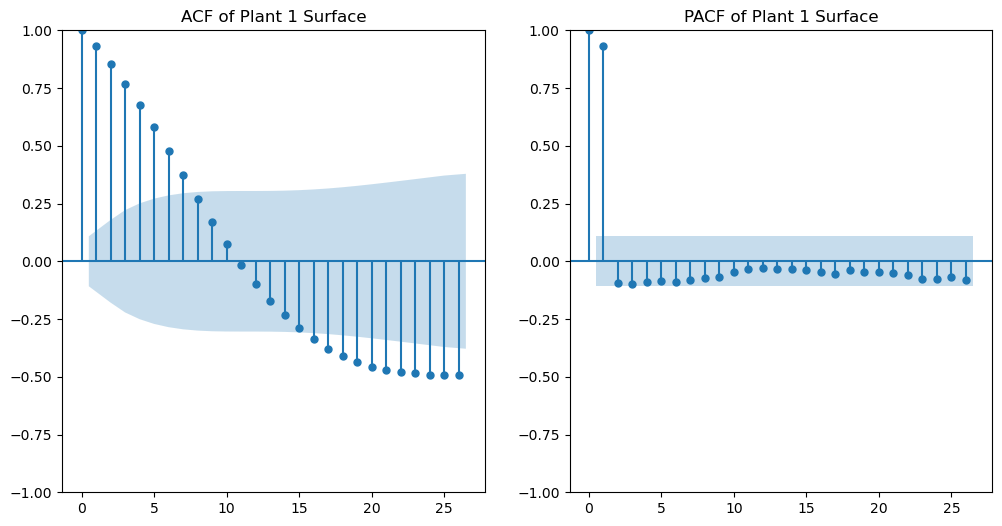

In [66]:
# Step 7: Plot ACF and PACF for this time series
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# ACF and PACF plots
plot_acf(train_gap_df["surface"].fillna(0), ax=ax1, title="ACF of Plant 1 Surface")
plot_pacf(train_gap_df["surface"].fillna(0), ax=ax2, title="PACF of Plant 1 Surface");

In [68]:
p=5
d=2
q=2

In [69]:
train_ser = train_gap_df.set_index('date')['surface']
model = ARIMA(train_ser, order=(p, d, q))
fitted_model = model.fit()

/opt/miniconda3/envs/pgp-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/pgp-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/pgp-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/pgp-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [87]:
forecast = fitted_model.get_forecast(len(test_days))
forecast_index = pd.date_range(start=train_ser.index[-1] + pd.Timedelta(days=1), 
                                   periods=len(test_days), freq='D')
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)
forecast_series

/opt/miniconda3/envs/pgp-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


2024-07-01     8.223079
2024-07-02    10.028693
2024-07-03    11.477929
2024-07-04    13.166799
2024-07-05    14.450998
2024-07-06    15.928702
2024-07-07    17.079353
2024-07-08    18.446806
2024-07-09    19.549448
2024-07-10    20.899692
2024-07-11    22.029890
2024-07-12    23.409022
2024-07-13    24.589214
2024-07-14    26.000070
2024-07-15    27.216927
2024-07-16    28.640003
2024-07-17    29.871397
2024-07-18    31.287792
2024-07-19    32.519042
2024-07-20    33.920626
2024-07-21    35.148141
2024-07-22    36.536231
2024-07-23    37.763235
2024-07-24    39.142931
2024-07-25    40.373839
2024-07-26    41.749400
Freq: D, dtype: float64

In [88]:
test_actual = test_df[(test_df["plant_num"] == "7") & test_df["days_from_start"].isin(test_days)].set_index('date')['surface']

In [90]:
test_actual

date
2024-07-01      8.127728
2024-07-02     10.657850
2024-07-03     13.149213
2024-07-04     16.593341
2024-07-05     25.508421
2024-07-06     33.495219
2024-07-07     46.227847
2024-07-08     58.530036
2024-07-09     71.900142
2024-07-10     89.251212
2024-07-11    109.046789
2024-07-12    127.389383
2024-07-13    151.049630
2024-07-14    178.551171
2024-07-15    199.774436
2024-07-16    214.225414
2024-07-17    216.424923
2024-07-18    219.029858
2024-07-19    219.883100
2024-07-20    221.780092
2024-07-21    224.506512
2024-07-22    226.433985
2024-07-23    228.777164
2024-07-24    228.890110
2024-07-25    226.745179
2024-07-26    225.427622
Name: surface, dtype: float64

In [93]:
mae = mean_absolute_error(test_actual, forecast_series)
mape = mean_absolute_percentage_error(test_actual, forecast_series)
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

MAE: 112.7737623395601
MAPE: 0.6772511086056208


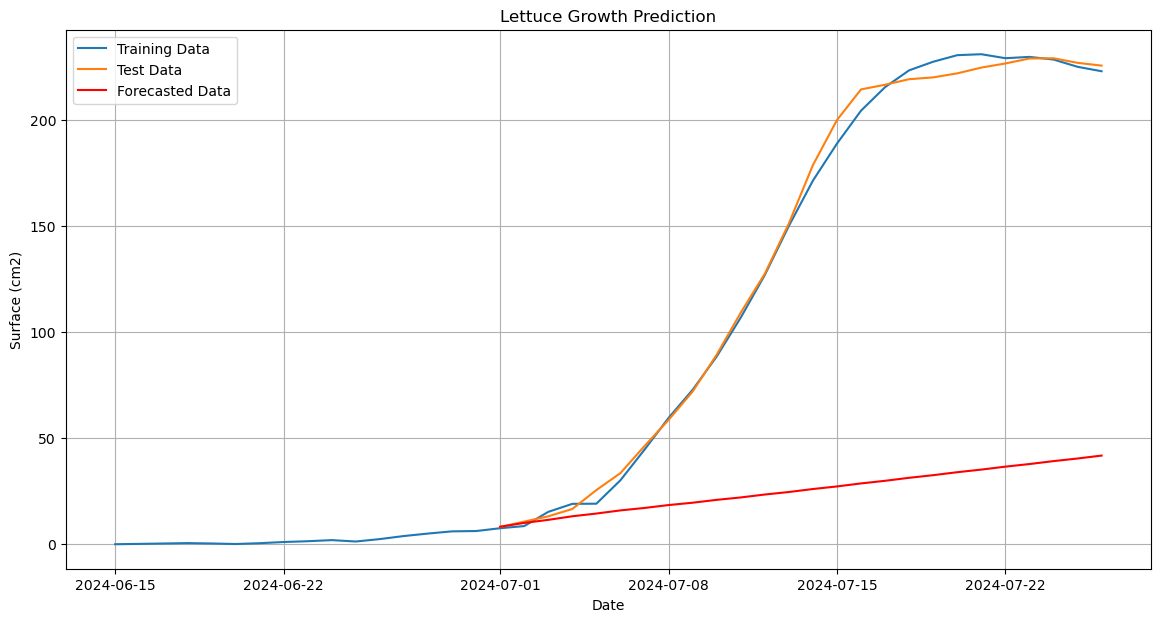

In [100]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(train_df[train_df['plant_num'] == '1'].set_index('date')['surface'], label='Training Data')
plt.plot(test_actual, label='Test Data')
plt.plot(forecast_series, label='Forecasted Data', color='red')
plt.xlabel('Date')
plt.ylabel('Surface (cm2)')
plt.title('Lettuce Growth Prediction')
plt.legend()
plt.grid()
plt.show()